In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install -q tf_keras tensorflow==2.12

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
dask-cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
pylibcudf 24.10.1 requires libcudf==24.10.*, which is not install

In [3]:
# Add timestamp
import datetime

print(f"Notebook current run time is :{datetime.datetime.now()}")

Notebook current run time is :2024-12-14 05:07:09.785468


In [4]:
! nvidia-smi

Sat Dec 14 05:07:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Transfer learning with tensorflow hub

In [5]:
# Get the data
import zipfile

# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip","r")

zip_ref.extractall()

zip_ref.close()

--2024-12-14 05:07:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 172.217.203.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

10_food_classes_10_ 100%[===================>] 160.74M   105MB/s    in 1.5s    

2024-12-14 05:07:13 (105 MB/s) - '10_food_classes_10_percent.zip' saved [168546183/168546183]



In [6]:
# how many images in each folder

import os

# walk through data directory and list number of files

for dirpath ,dirnames,filenames in os.walk("/kaggle/working/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /kaggle/working/10_food_classes_10_percent
There are 10 directories and 0 images in /kaggle/working/10_food_classes_10_percent/test
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in /kaggle/working/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images 

# Creating data loaders (preparing the data)

In [7]:

# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Setting up tensorflow callbacks for tracking experimentation

In [8]:
def create_tensorboard_callbacks(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f"Saving Tensorboard log files to :{log_dir}")

  return tensorboard_callback


# Lets trained our feature extraction transfer learning model

In [9]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [26]:
# set url of models
resnet_url="https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"

efficientnet_url="https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"

In [28]:
def create_model(model_url,num_classes=10):
   # download pretrained model

    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer-2',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
      feature_extractor_layer, # use the feature extraction layer as the base
      layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
    ])

    return model

In [12]:
#create model
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [13]:
#compile model
resnet_model.compile(
                    loss="categorical_crossentropy",
                     optimizer='adam',
                     metrics=['accuracy']
                     )

In [15]:
#fit the model
resnet_history=resnet_model.fit(
                                train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="resnetv2")]
                                )




Saving Tensorboard log files to :tensorflow_hub/resnetv2/20241214-052837
Epoch 1/5
24/24 [==============================] - 304s 13s/step - loss: 0.5265 - accuracy: 0.8333 - val_loss: 0.7849 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 289s 12s/step - loss: 0.4370 - accuracy: 0.8640 - val_loss: 0.7374 - val_accuracy: 0.7572
Epoch 3/5
24/24 [==============================] - 286s 12s/step - loss: 0.3685 - accuracy: 0.8960 - val_loss: 0.7311 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 286s 12s/step - loss: 0.3070 - accuracy: 0.9200 - val_loss: 0.7223 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 328s 14s/step - loss: 0.2544 - accuracy: 0.9493 - val_loss: 0.7141 - val_accuracy: 0.7688


In [18]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


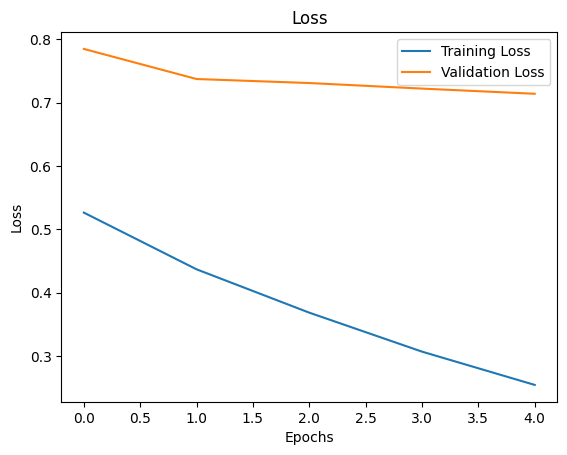

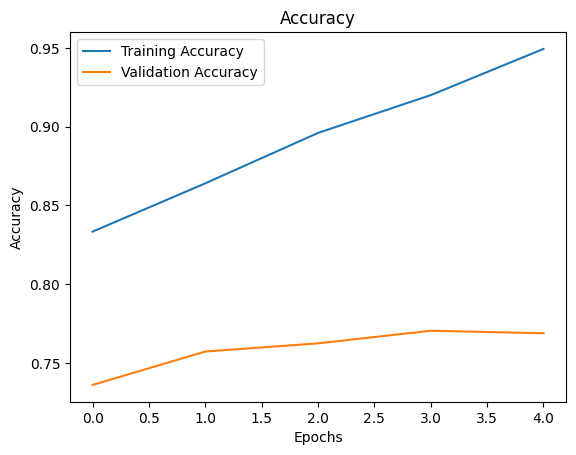

In [19]:
#plot curves for resnet model 
plot_loss_curves(resnet_history)

In [20]:
#resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             44677609  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44,687,629
Trainable params: 10,020
Non-trainable params: 44,677,609
_________________________________________________________________


# EfficientNet Model 

In [30]:

# Setup data inputs for mobilenet model requeres (128,128,3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (128, 128)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent_m = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data_m= train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [35]:
# create model 
mobilenet_model=create_model(efficientnet_url,num_classes=train_data_10_percent.num_classes)

#compile model 
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit the model 
mobilenet_model_history=mobilenet_model.fit(
    train_data_10_percent_m,
    epochs=15,
    steps_per_epoch=len(train_data_10_percent_m),
    validation_data=test_data_m,
    validation_steps=len(test_data_m),
    callbacks=[create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="mobilenet")]
)

Saving Tensorboard log files to :tensorflow_hub/mobilenet/20241214-062432
Epoch 1/15
24/24 [==============================] - 14s 451ms/step - loss: 2.5801 - accuracy: 0.2533 - val_loss: 1.8184 - val_accuracy: 0.4160
Epoch 2/15
24/24 [==============================] - 10s 427ms/step - loss: 1.3200 - accuracy: 0.5800 - val_loss: 1.4058 - val_accuracy: 0.5452
Epoch 3/15
24/24 [==============================] - 10s 408ms/step - loss: 0.9883 - accuracy: 0.6827 - val_loss: 1.3046 - val_accuracy: 0.5884
Epoch 4/15
24/24 [==============================] - 10s 438ms/step - loss: 0.7937 - accuracy: 0.7600 - val_loss: 1.2344 - val_accuracy: 0.6088
Epoch 5/15
24/24 [==============================] - 9s 407ms/step - loss: 0.6689 - accuracy: 0.8053 - val_loss: 1.2143 - val_accuracy: 0.6132
Epoch 6/15
24/24 [==============================] - 9s 403ms/step - loss: 0.5743 - accuracy: 0.8227 - val_loss: 1.2034 - val_accuracy: 0.6232
Epoch 7/15
24/24 [==============================] - 13s 538ms/step - l

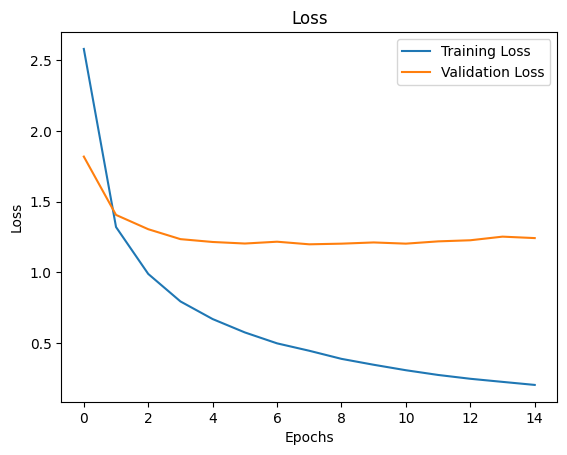

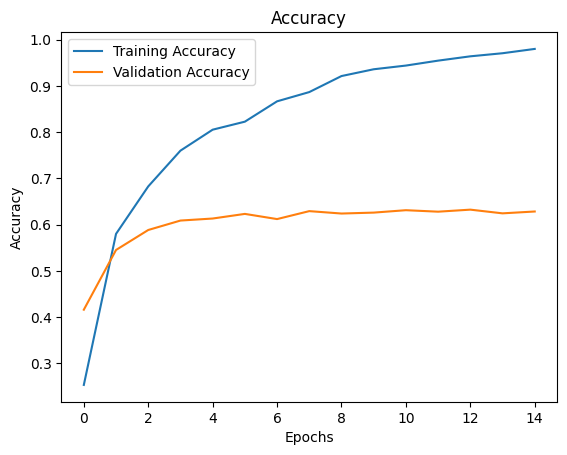

In [36]:
#plot curves for efficientnet model 
plot_loss_curves(mobilenet_model_history)

In [37]:
mobilenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer-2   (None, 1001)             1692489   
 (KerasLayer)                                                    
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 1,702,509
Trainable params: 10,020
Non-trainable params: 1,692,489
_________________________________________________________________


# Comparing models using TensorBoard

In [53]:
test_data_m[0][0].shape

(32, 128, 128, 3)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

79/79 [==============================] - 223s 3s/step


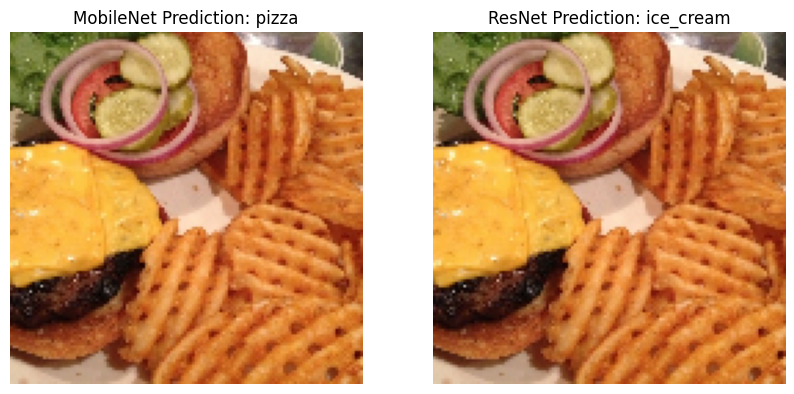

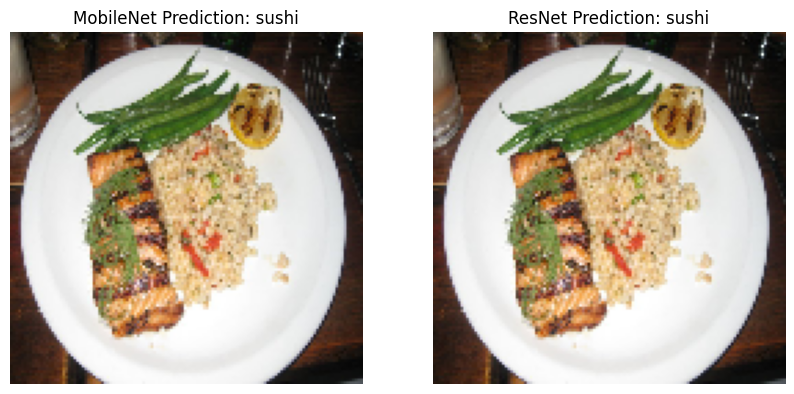

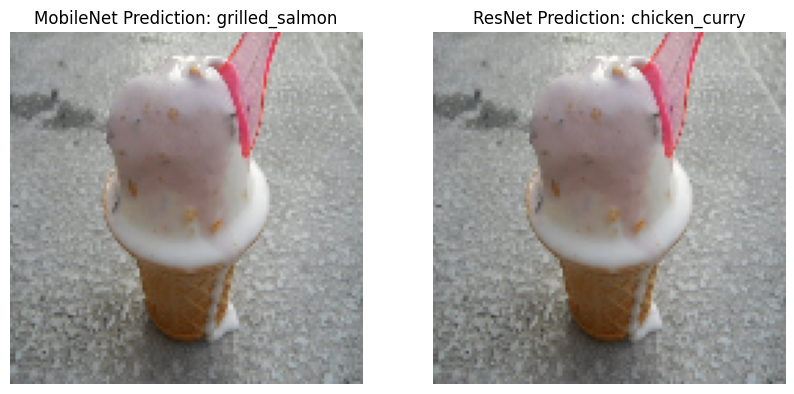

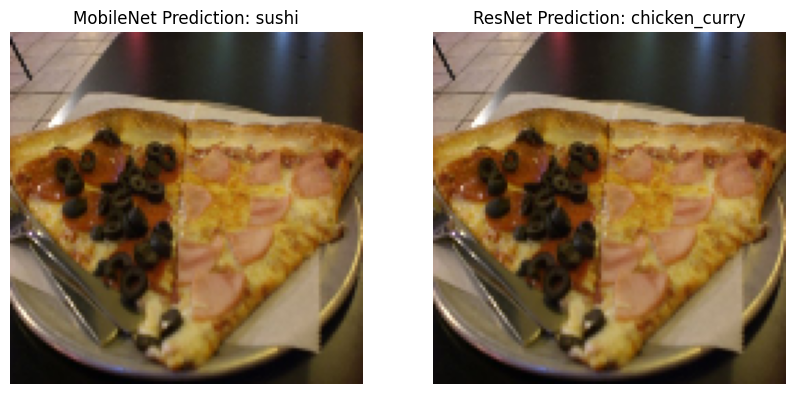

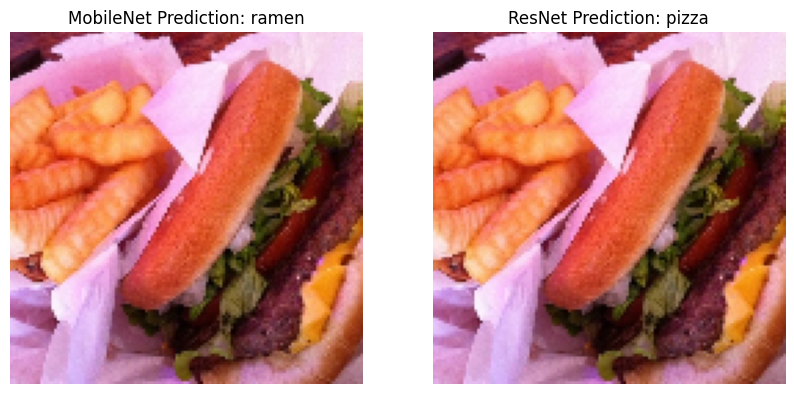

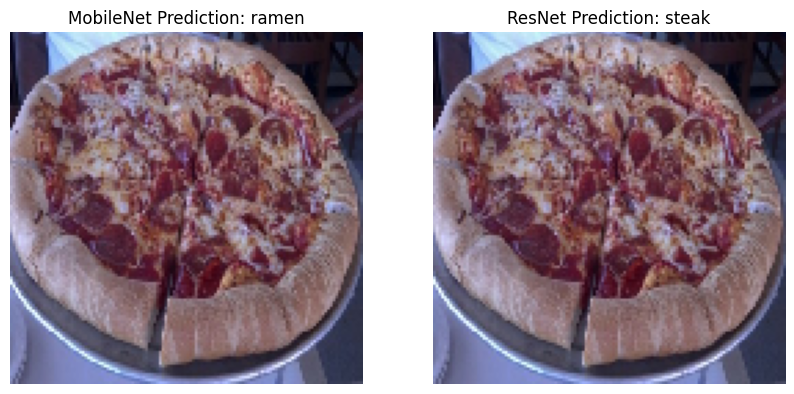

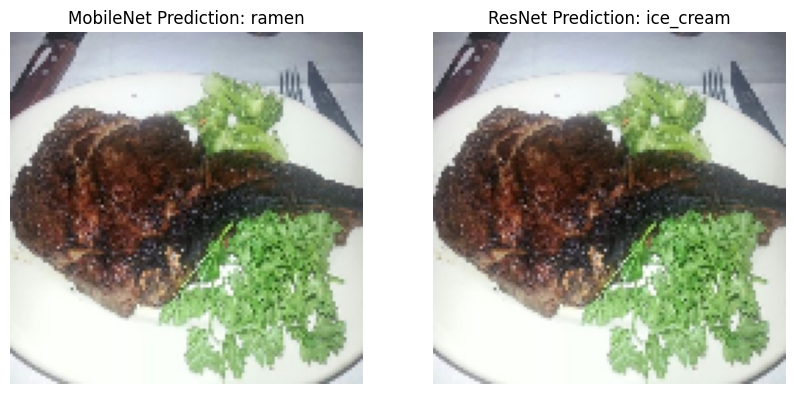

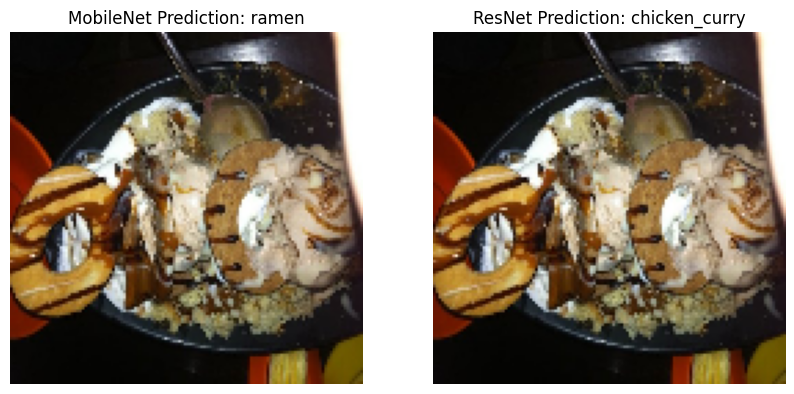

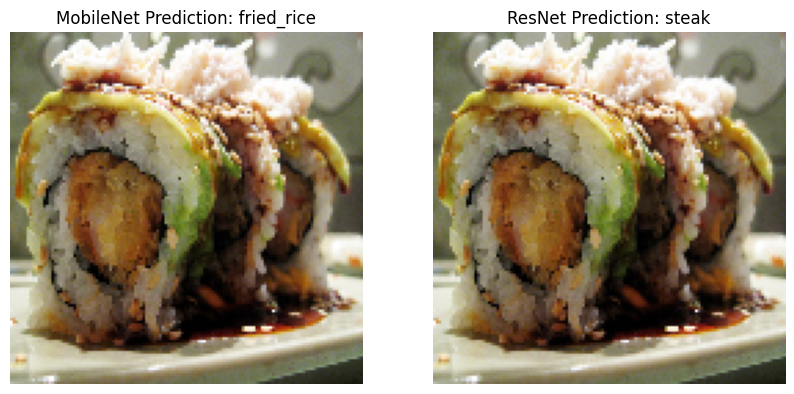

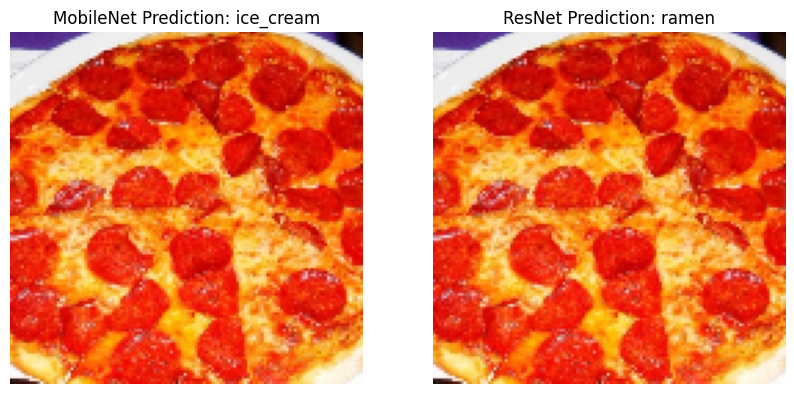

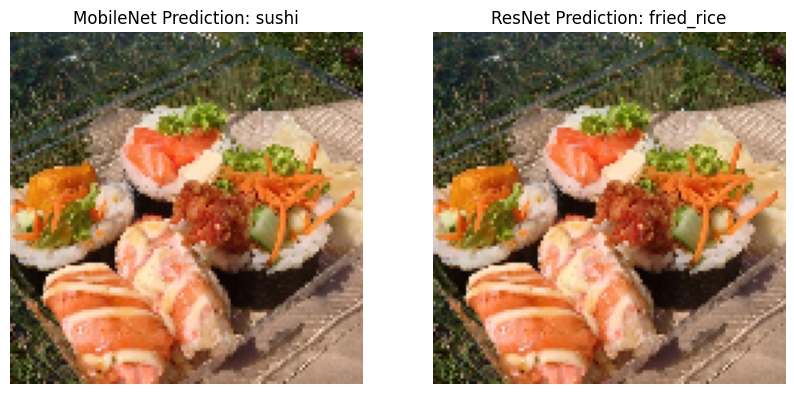

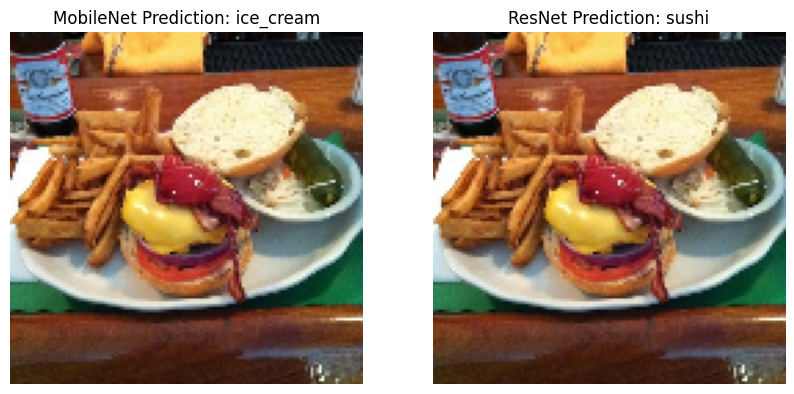

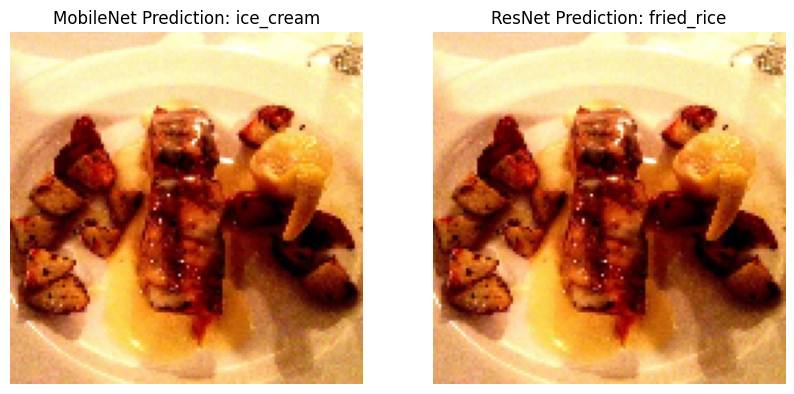

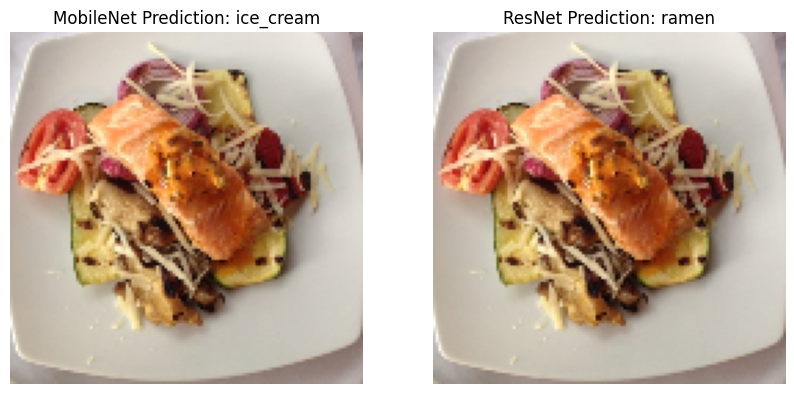

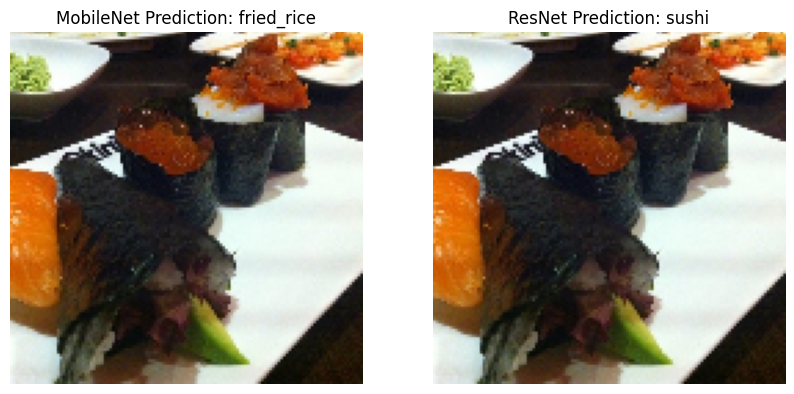

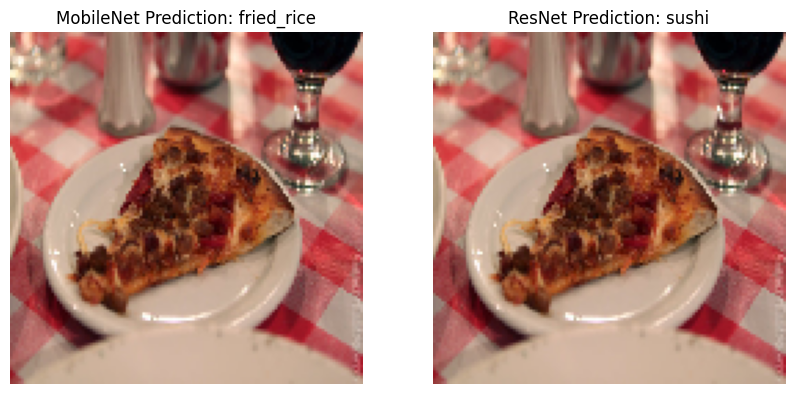

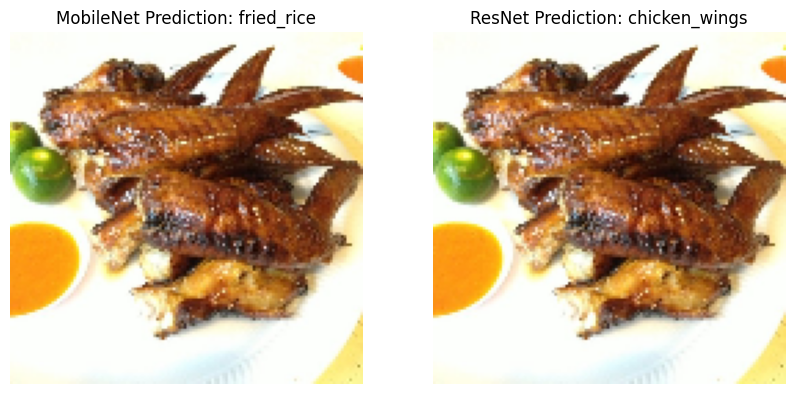

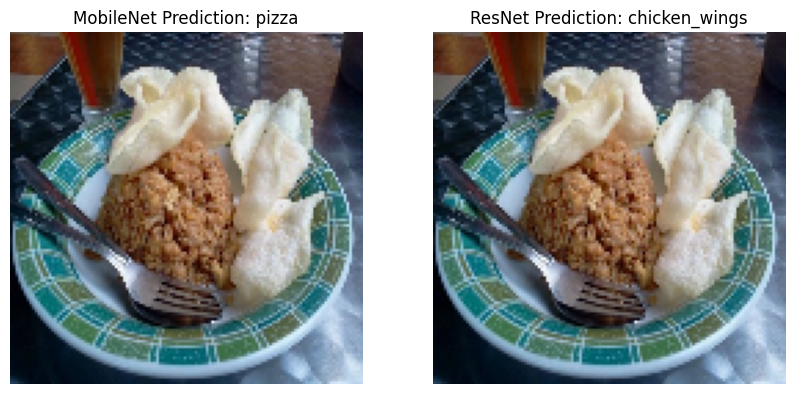

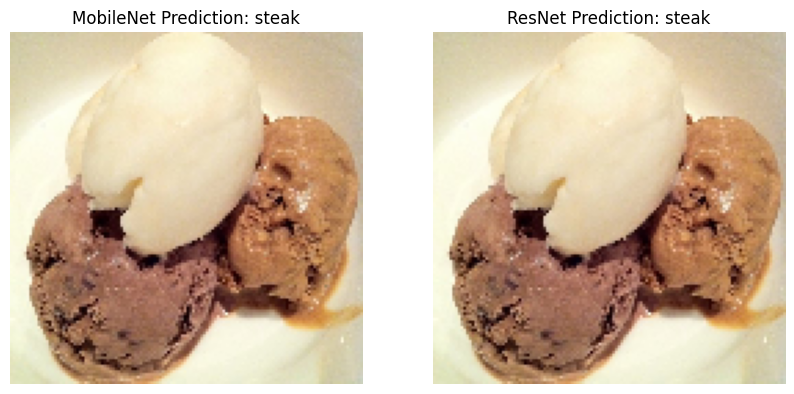

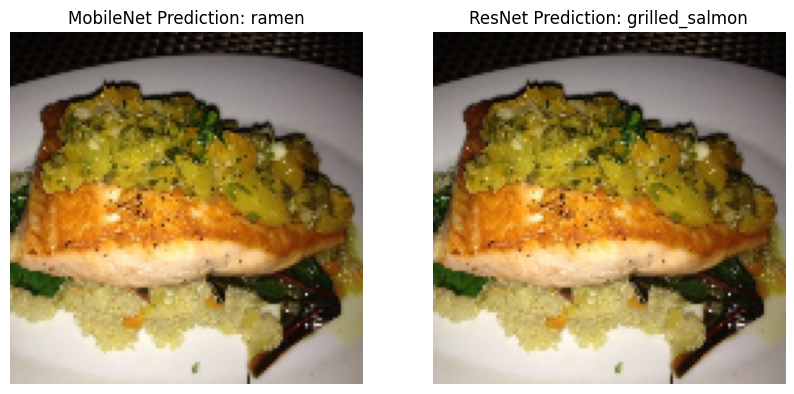

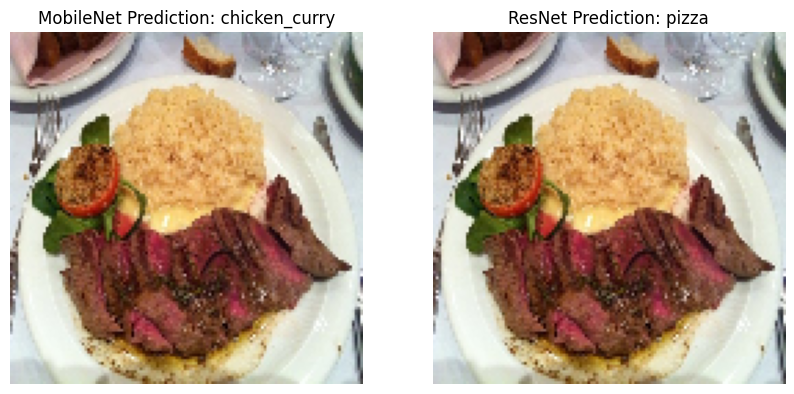

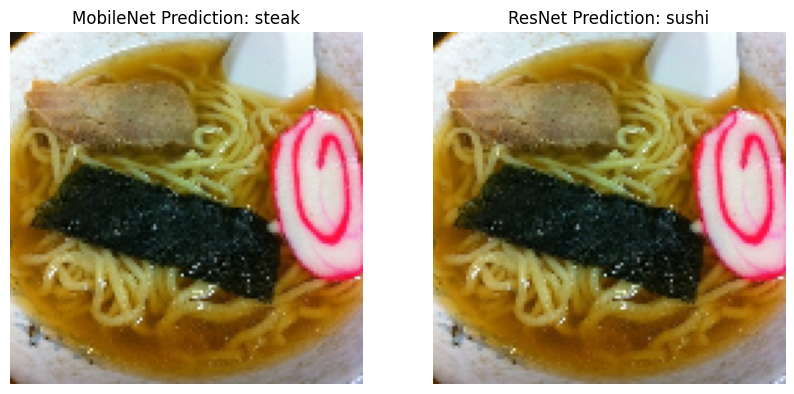

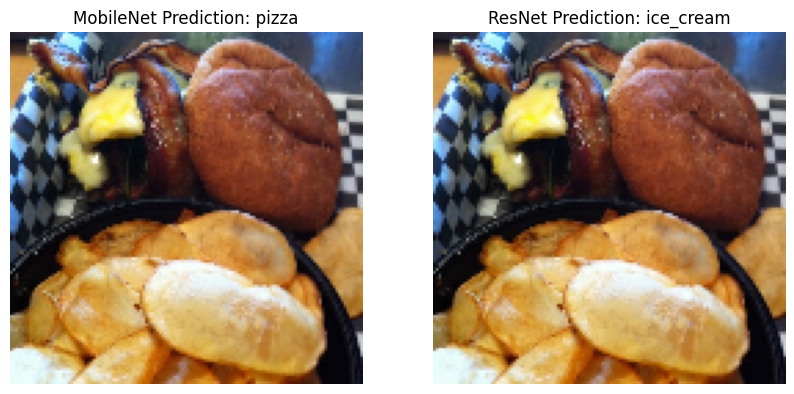

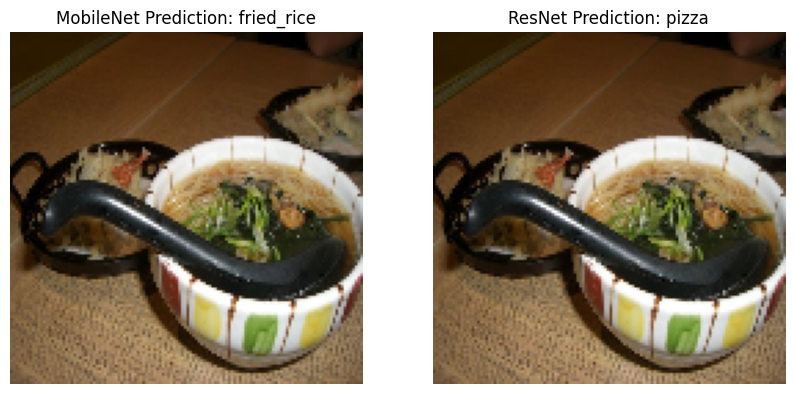

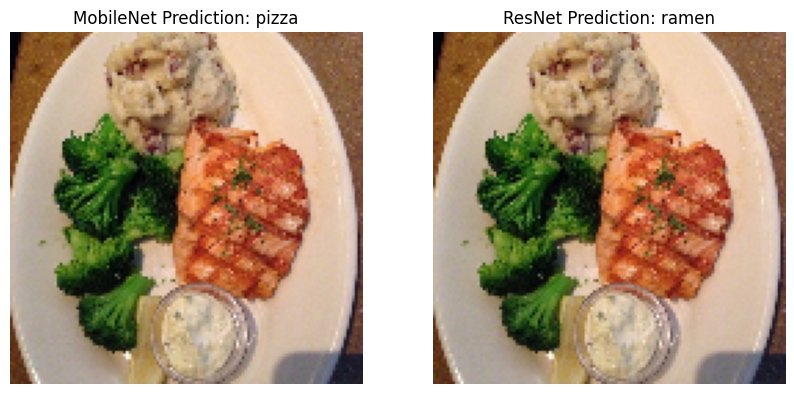

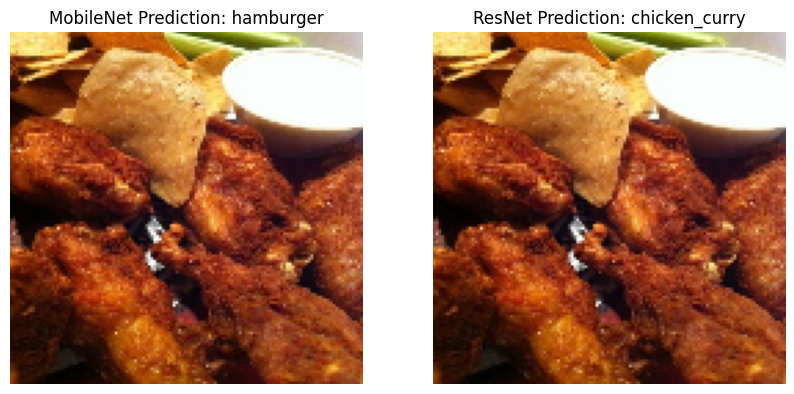

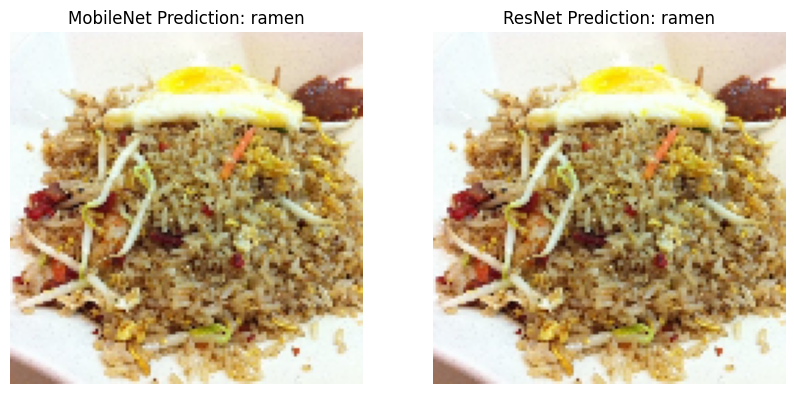

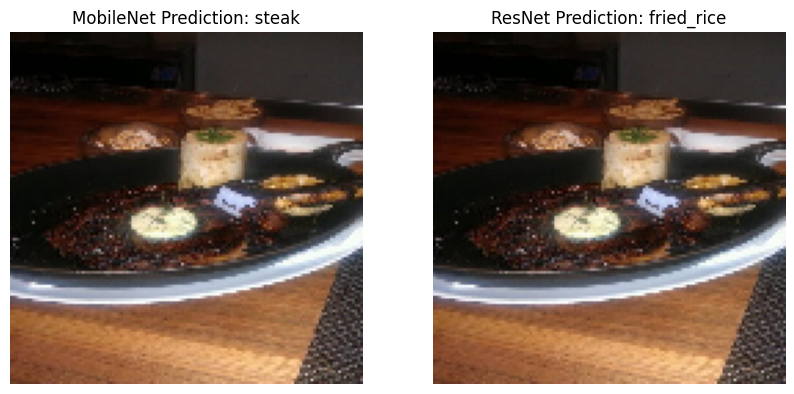

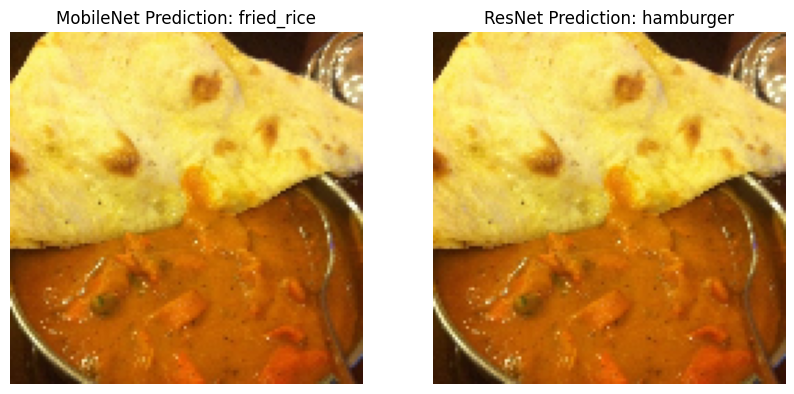

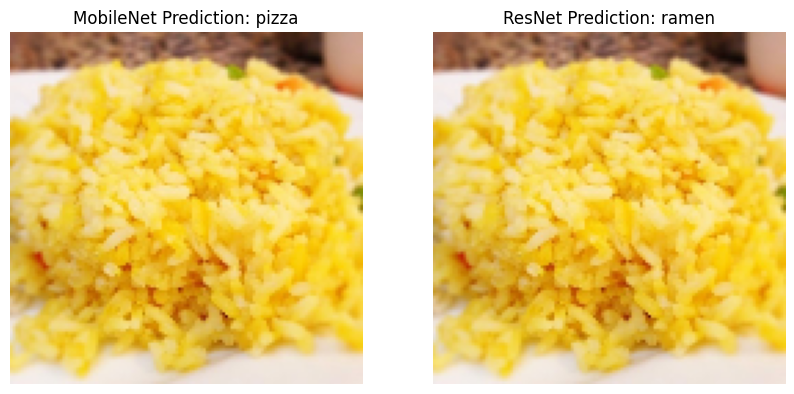

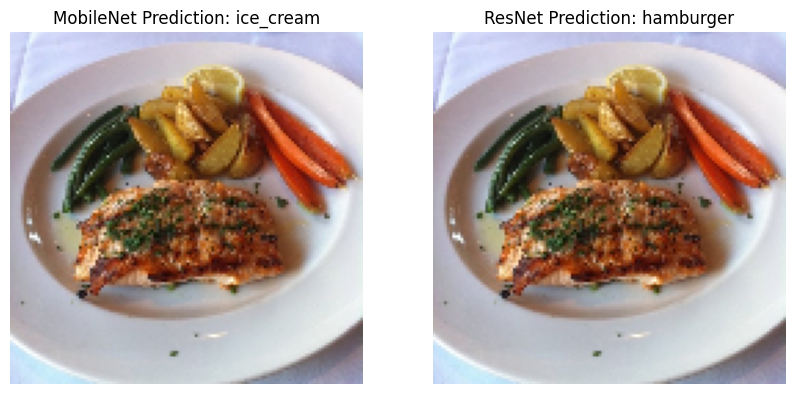

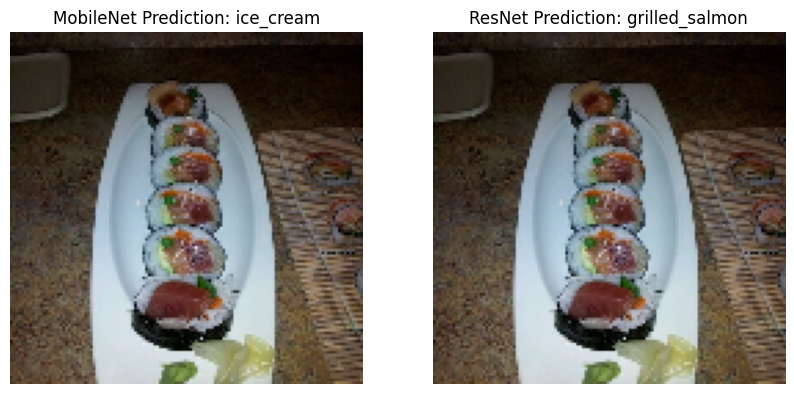

In [57]:
# # Get predictions for the test data
# predictions = mobilenet_model.predict(test_data_m)

# # Get the predicted class labels (indices)
# predicted_classes = np.argmax(predictions, axis=-1)

# # Get the class names from the class indices
# class_names = test_data_m.class_indices.keys()
# class_names = list(class_names) 

# # Display the first batch of images with their predicted class names
# for i in range(BATCH_SIZE):
#     img = test_data_m[0][0][i]
#     predicted_class_name = class_names[predicted_classes[i]] 
#     plt.imshow(img) 
#     plt.title(f"Predicted Class: {predicted_class_name}")
#     plt.axis('off')
#     plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Make predictions for the test data from both models
predictions_mobilenet = mobilenet_model.predict(test_data_m)
predictions_resnet = resnet_model.predict(test_data)

# Get the predicted class labels (indices) from both models
predicted_classes_mobilenet = np.argmax(predictions_mobilenet, axis=-1)
predicted_classes_resnet = np.argmax(predictions_resnet, axis=-1)

# Get the class names from the class indices
class_names = test_data_m.class_indices.keys()
class_names = list(class_names)

# Display the first batch of images with predictions from both models side by side
for i in range(BATCH_SIZE):
    img = test_data_m[0][0][i]  # Access the i-th image in the batch
    
    # Get predictions for both models
    predicted_class_name_mobilenet = class_names[predicted_classes_mobilenet[i]]
    predicted_class_name_resnet = class_names[predicted_classes_resnet[i]]
    
    # Plot the image and both model's predictions side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a subplot with 1 row and 2 columns
    
    # Display the image and MobileNet prediction
    axes[0].imshow(img)
    axes[0].set_title(f"MobileNet Prediction: {predicted_class_name_mobilenet}")
    axes[0].axis('off')
    
    # Display the image and ResNet prediction
    axes[1].imshow(img)
    axes[1].set_title(f"ResNet Prediction: {predicted_class_name_resnet}")
    axes[1].axis('off')
    
    plt.show()
